In [64]:
import warnings
warnings.filterwarnings("ignore")

import scipy.stats as stats
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp as ks

from plotly.offline import init_notebook_mode, iplot, download_plotlyjs
import plotly.offline as pyo
import cufflinks as cf
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
cf.go_offline()

In [84]:
dist1 = np.random.normal(0,10,size=(3000,1)).flatten()
dist2 = np.random.normal(4,8.5,size=(3000,1)).flatten()

In [178]:
df = pd.DataFrame(np.dstack([dist1,dist2]).reshape(3000,2), columns=['std_0_100', 'std_4_85'])
df.iplot(kind='hist')

In [92]:
def ecdf(data):
    n = data.shape[0]
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

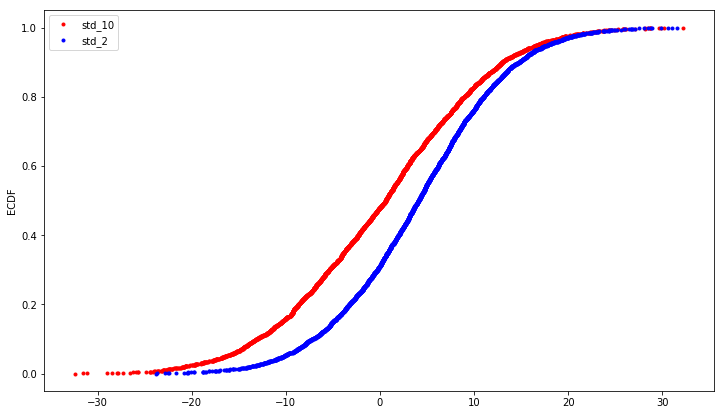

In [85]:
_ = plt.figure(figsize=(12,7))
_ = plt.plot(ecdf(dist1)[0],ecdf(dist1)[1], marker='.', linestyle='none', color='red')
_ = plt.plot(ecdf(dist2)[0],ecdf(dist2)[1], marker='.', linestyle='none', color='blue')
_ = plt.legend(['std_10','std_2'])
_ = plt.ylabel('ECDF')

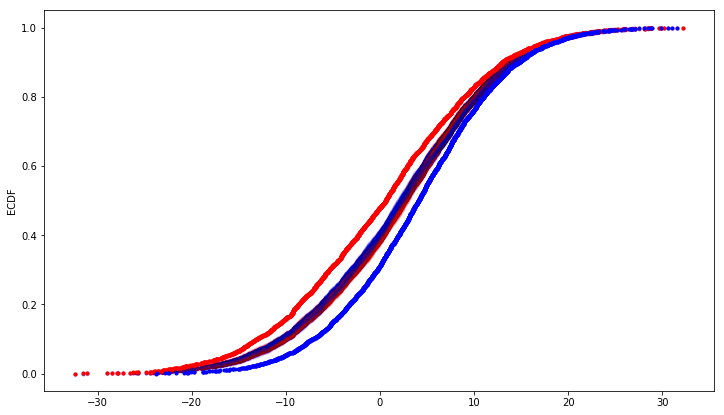

In [88]:
_ = plt.figure(figsize=(12,7))

for i in range(50):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(dist1, dist2)


    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    _ = plt.plot(x_1, y_1, marker='.', linestyle='none',
                 color='red', alpha=0.02)
    _ = plt.plot(x_2, y_2, marker='.', linestyle='none',
                 color='blue', alpha=0.02)

_ = plt.plot(ecdf(dist1)[0],ecdf(dist1)[1], marker='.', linestyle='none', color='red')
_ = plt.plot(ecdf(dist2)[0],ecdf(dist2)[1], marker='.', linestyle='none', color='blue')
# _ = plt.legend(['std_10','std_2'])
_ = plt.ylabel('ECDF')

In [164]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)

    return perm_replicates

In [89]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(dist1, dist2)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(dist1, dist2,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

p-value = 1.0


In [99]:
ecdf(dist1)[1] - ecdf(dist2)[1]

array([0., 0., 0., ..., 0., 0., 0.])

In [140]:
from scipy.interpolate import interp1d

In [149]:
def KS(data_1, data_2, ecdf=ecdf):
    
    dists = pd.Series(np.sort(np.unique(np.concatenate((dist1,dist2)))), name='x').to_frame()
    dists = dists.merge(pd.DataFrame(np.array(ecdf(data_1)).T).rename(columns={0:'x',1:'dist1'}),how='left')
    dists = dists.merge(pd.DataFrame(np.array(ecdf(data_2)).T).rename(columns={0:'x',1:'dist2'}),how='left')
    dists['dist2'].at[0] = 0
    dists['dist2'].at[dists.shape[0]] = 1.0
    dists.set_index('x',inplace=True)
    for dist in dists.columns:
        dists[dist] = dists[dist].interpolate()

    KS = np.round(np.max(np.abs(dists['dist1']-dists['dist2'])),4)

    return KS

In [144]:
KS(dist1,dist2)

0.1758

In [181]:
ks(dist1,dist2)[0]

0.17600000000000002

In [141]:
dists = pd.Series(np.sort(np.unique(np.concatenate((dist1,dist2)))), name='x').to_frame()
dists = dists.merge(pd.DataFrame(np.array(ecdf(dist1)).T).rename(columns={0:'x',1:'dist1'}),how='left')
dists = dists.merge(pd.DataFrame(np.array(ecdf(dist2)).T).rename(columns={0:'x',1:'dist2'}),how='left')
dists['dist2'].at[0] = 0
dists['dist2'].at[dists.shape[0]] = 1.0
dists.set_index('x',inplace=True)
for dist in dists.columns:
    dists[dist] = dists[dist].interpolate()
dists.iplot()

In [177]:
empirical_KS = ks(dist1, dist2)[0]

perm_replicates = draw_perm_reps(dist1, dist2, lambda x, y : ks(x,y)[0], size=100000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_KS) / len(perm_replicates)

# Print the result
print('p-value =', p)

p-value = 0.0
